# Monte Carlo event generation and integration

You can view these sheets on github, but to modify them, you'll need to a version of jupyter. How to install it is explained here: http://jupyter.readthedocs.io/en/latest/install.html.
If you want to use the functions defined below to generate your own distributions, you need to compile them first. Easiest done by clicking (once have opened this as jupyter notebook): Kernel -> Restart & Run All. (Alternatively, you can use the >| button to click your way through, but you need to start from the beginning to have access to all functions defined on this sheet). Have fun!

## The aim:
1) We want to generate random events. 

2) We want to use this to integrate f(x).

3) We will want to use that to generate random events distributed in x according to f(x) (where we interpret f(x) as a probability density function)

4) We'll write our code such that it works for *any* f(x). More or less.

Step 1: import the usual libraries:

In [1]:
from math import *
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

Even if we want to write the code to be able to accept general function, it is useful to start off with specific example. Let's use the one we had in the class: a quarter of the unit circle. $f(x) = \sqrt{1-x^2}$ for $x \in [0,1]$ and $f(x)=0$ elsewhere. We write the function such that it 

In [2]:
# python, and especially numpy, like to operate on arrays. So while our function does this
#    if x > 0 and x < 1:
#        return sqrt(1-x*x)
#    else:
#        return 0
# below we implement this as an operation over an array. Note that we can still pass single values if we want
# they will be interpreted as "arrays of length one" (sorry the code is a bit obscure)
#
def quarterCircle(xArray, xmin=0, xmax=0):  # we'll need xmin, xmax for future compatibility
    #return [sqrt(1-x**2) if x > 0 and x < 1 else 0 for x in xArray]
    return np.where(np.logical_or(xArray <=0, xArray >= 1), 0, np.sqrt(np.abs(1-xArray**2)))

# Try it out:
print("0:", quarterCircle(0.), "; 0.5:", quarterCircle(0.5))

0: 0.0 ; 0.5: 0.8660254037844386


Now I would like to have a look at the function I wrote, so I want to plot it. Since I will want to plot many functions, I'll write a "plot function" routine:

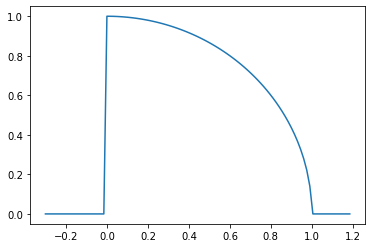

In [3]:
def plotFunction(f, minx, maxx, numpoints=100, scaleFactor=1):
    #make the x-values:
    stepsize = float(maxx-minx)/numpoints
    x = np.arange(minx, maxx, stepsize)
    plt.plot(x, f(x, minx, maxx)*scaleFactor)
    
# let's try it out:
plotFunction(quarterCircle, -0.3, 1.2)
plt.show()

Now let's generate some random events

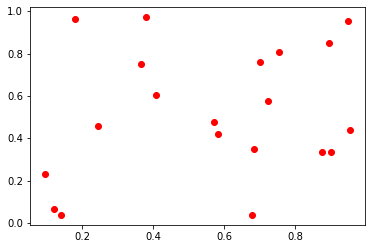

In [4]:
def makeRandomEvents(xmin, xmax, ymin, ymax, howMany):
        xArray=(xmin + np.random.random(howMany)*(xmax-xmin))
        yArray=(ymin + np.random.random(howMany)*(ymax-ymin))
        return [xArray, yArray]

def plotRandomNumbers(Numbers):
    plt.plot(Numbers[0],Numbers[1], 'ro')
    
#try it:
Numbers = makeRandomEvents(0, 1, 0, 1, 20)
plotRandomNumbers(Numbers)
plt.show()

Let's now plot the function and the numbers in the same plot

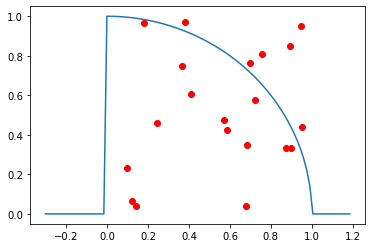

In [5]:
plotFunction(quarterCircle, -0.3, 1.2)
plotRandomNumbers(Numbers)
plt.show()

Now we could do the MC-integration ourselves by counting events inside and outide the circle. But let's let python do this for us.

In [6]:
def MCIntegration(f, xmin, xmax, ymax, howMany, plotopt="withPlot"):
        Numbers=makeRandomEvents(xmin, xmax, 0, ymax, howMany)
        
        counter=0
        for x, y in zip(Numbers[0], Numbers[1]):
            if y < f(x, xmin, xmax):
                counter = counter + 1
                
        fractionInside = float(counter)/len(Numbers[0])
        boxsize        = (xmax-xmin)*ymax
        integralValue  = fractionInside * boxsize
        
        uncertainty    = sqrt(howMany*fractionInside*(1-fractionInside))/howMany*boxsize  # your task: get the uncertainty right.
        if plotopt == "withPlot":
            plotRandomNumbers(Numbers)
            plotFunction(f, xmin, xmax)
            plt.show()
            print("integral value = ", integralValue, " +- ", uncertainty)
            
        return integralValue, uncertainty
                

Let's try it out:

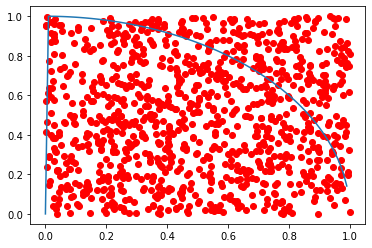

integral value =  0.777  +-  0.013163244280951409
pi =  3.108  +-  0.052652977123805636


In [7]:
result = MCIntegration(quarterCircle, 0, 1, 1, 1000)
print("pi = ", result[0]*4, " +- ", result[1]*4)
#print("Your task: calculate the uncertainty correctly")

## Task: Edit the code above to calculate the uncertainty on the value of pi and then do a pull study to test you got it right.

In [8]:
def checkError(howOften):
    sigmaArray = []
    sum_sigma=0
    sumsq_sigma=0
    for i in range(howOften):
        result=MCIntegration(quarterCircle,0,1,1,1000,plotopt="noPlots")
        nb_sigma=(4.*result[0]-np.pi)/(4.*result[1])
        sigmaArray.append(nb_sigma)
        sum_sigma+=nb_sigma
        sumsq_sigma+=nb_sigma**2
        if i < 3:
            print("result ",4*result[0], "is ", nb_sigma, "sigma away from pi = ", np.pi)
    
    mean=sum_sigma/howOften
    meansq=sumsq_sigma/howOften
    Var=meansq-mean**2
    standDev=sqrt(Var)
    meanStandDev=standDev/sqrt(howOften)
    onmeanStandDev=standDev/sqrt(2*howOften)
    print("Mean = ", mean, " +- ", meanStandDev, ", sigma = ", standDev , " +- ", onmeanStandDev)
    plt.hist(sigmaArray,50,range=(-5,5))
    plt.show()

result  3.172 is  0.5933306234278924 sigma away from pi =  3.141592653589793
result  3.192 is  0.9925598733052171 sigma away from pi =  3.141592653589793
result  3.16 is  0.35727942032360294 sigma away from pi =  3.141592653589793
Mean =  0.04064013961459037  +-  0.03276549571561676 , sigma =  1.036135951258376  +-  0.023168704209451375


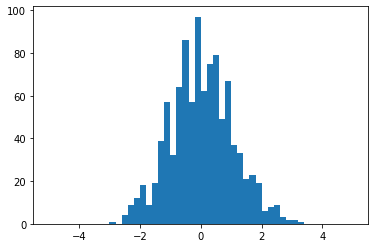

In [9]:
checkError(1000)

# Event Generation
Let's now use the MC technique to generate events. All we need to do is throw away those events that are outside the region between the x axis and f(x). Important for this: f(x) needs to be normalised! Our circle function is not.

In [10]:
def indefIntegralQuarterCircle(x):
    return 0.5*(x*np.sqrt(1-x**2) + np.arcsin(x))
                
def defIntegralQuarterCircle(xmin, xmax):
    a=xmin
    b=xmax
    if xmin < 0 : 
        a=0
    if xmax > 1 :
        b=xmax
    return indefIntegralQuarterCircle(b) - indefIntegralQuarterCircle(a)
                
def normalisedQuarterCircle(x, xmin, xmax):
    #integrate y=sqrt(1-x^2) from xmin to xmax
    return quarterCircle(x)/defIntegralQuarterCircle(xmin, xmax)
                

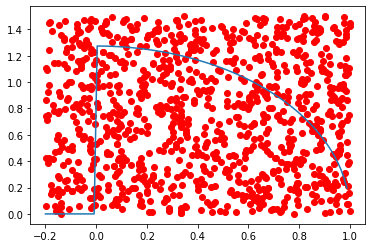

integral value =  0.9863999999999999  +-  0.028329049401630117


(0.9863999999999999, 0.028329049401630117)

In [11]:
#check I got normalisation right:
MCIntegration(normalisedQuarterCircle, -0.2, 1, 1.5, 1000) #make sure you get maximum right!!

In [12]:
def MCGeneration(f, xmin, xmax, ymax, howMany, plotopt="withPlot"):
        Numbers=makeRandomEvents(xmin, xmax, 0, ymax, howMany)
        
        outputArray=[]
        counter=0
        for x, y in zip(Numbers[0], Numbers[1]):
            if y < f(x, xmin, xmax):
                outputArray.append(x)

        if(plotopt == "withPlot"):
            nbins=100
            if howMany/nbins < 10:
                nbins = int(howMany/10)
            
            binwidth=(xmax-xmin)/nbins
            plotFunction(f, xmin, xmax, scaleFactor=binwidth*len(outputArray))
            plt.hist(outputArray, nbins, range=(xmin,xmax))
            plt.show()
        return outputArray
    
# (there must be a more pyton-esque qay of doing this, but this is fairly easy to read)

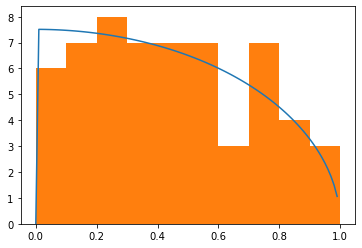

In [13]:
GeneratedEvents = MCGeneration(normalisedQuarterCircle, 0, 1, 1.5, 100)
#print(GeneratedEvents[:10]) # prints the first 10 events

Let's try another function: f(x) = x^2 for example

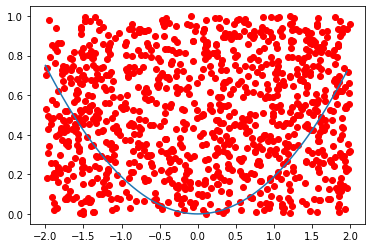

integral value =  1.02  +-  0.055132567507780735


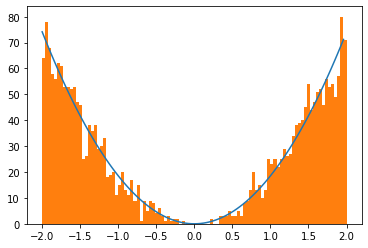

In [14]:
def NormalisedParabola(x, xmin, xmax):
    return x**2 * 3/(xmax**3-xmin**3)

MCIntegration(NormalisedParabola, -2, 2, 1, 1000)
ParabolaArray=MCGeneration(NormalisedParabola, -2, 2, 1, 10000)

## Your task: Many things to try out: Try out what happens if you get the value of ymax wrong (too big, too small), play with other functions, etc.

We start by testing the consequences of a wrong ymax value. We take the quarter square function and a ymax value at 0.5

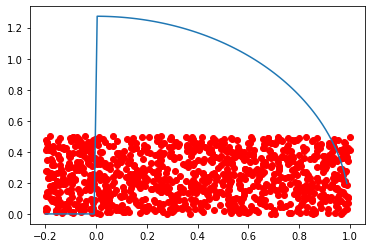

integral value =  0.4728  +-  0.0077550087040570105


(0.4728, 0.0077550087040570105)

In [15]:
MCIntegration(normalisedQuarterCircle, -0.2, 1, 0.5, 1000)

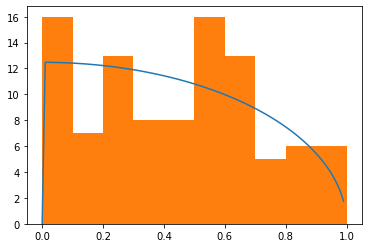

In [16]:
GeneratedEvents = MCGeneration(normalisedQuarterCircle, 0, 1, 0.5, 100)

As we can see, events above y=0.5 aren't taken into account. Therefore it is impossible for the program to find the function form and to reproduce it.

Now we will try another function.

In [17]:
def invExp(x,xmin,xmax):
    return 2/(np.exp(-2*xmin)-np.exp(-2*xmax))*np.exp(-2*x)

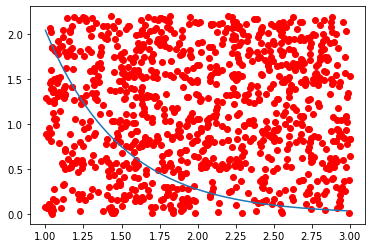

integral value =  0.9064  +-  0.056272542505204096


(0.9064, 0.056272542505204096)

In [18]:
MCIntegration(invExp, 1, 3, 2.2, 1000)

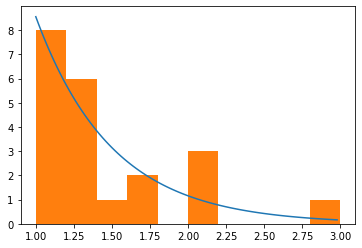

In [19]:
GeneratedEvents = MCGeneration(invExp, 1, 3, 2.2, 100)